# Weather Forecaster

Import the nessesary packages:

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.layers.convolutional import Conv1D, MaxPooling1D
import pandas as pd
from sklearn.preprocessing import StandardScaler
%matplotlib inline

Using TensorFlow backend.


Define the model, using a function makes it easy to reuse or test it with different parameters.

In [2]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
  model = Sequential()
  model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', 
                   input_shape=(window_size,nb_input_series)))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(nb_outputs,activation='linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model


The data have to be modified to feed in like a time series.
With the delay parameter we can set the predicted interval. 
If we want to predict the weather tomorrow based on the previous 20 day we set the window_size to 20 and the delay to 0. 
If we want to predict the weather 1 week (7days) in a future based on the previous 20 day we set the window_size to 20 and the delay to 7. 

In [23]:
def make_timeseries_instances(timeseries,window_size, delay):
  timeseries = np.asarray(timeseries)
  assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
  X = np.atleast_3d(np.array([timeseries[start:start+window_size] for start in range(0,timeseries.shape[0]-(window_size+delay))]))
  y = timeseries[(window_size+delay):]
  return X,y

In [24]:
def evalute_timeseries(timeseries,window_size, delay):
  filter_length = 5
  nb_filter = 4
  timeseries = np.atleast_2d(timeseries)
  if timeseries.shape[0] == 1:
    timeseries = timeseries.T
  nb_samples, nb_series = timeseries.shape
  
  model= make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series,
                        nb_outputs=nb_series,nb_filter=nb_filter)
  model.summary()
  
  X,y = make_timeseries_instances(timeseries, window_size, delay)
  
  test_size = int(0.3  * nb_samples)
  X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
  
  model.fit(X_train,y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=2)
  
  preds=model.predict(X_test)
  targets = y_test
  
  print(X_train.shape)
  print(y_train.shape)
  
  plt.plot(preds)
  plt.plot(targets)

# Load data

In [5]:
# Read in DataFram from file
df = pd.read_csv("weaterv2.csv", sep=';')

In [6]:
df.shape

(2060, 21)

In [7]:
# DataFrame check
df.head()

,Year,Month,Day,Tmax,Tavg,Tmin,DewMax,DewAvg,DewMin,Hmax,...,Hmin,WindMax,WindAvg,WindMin,Pmax,Pavg,Pmin,PreMax,PreAvg,PreMin
0,1999,1,1,-4,-7,-10,-4,-7,-10,100,...,93,13,-,0,1029,-,1024,-,0.0,-
1,1999,1,2,-1,-4,-7,-2,-4,-7,100,...,93,16,-,0,1024,-,1017,-,0.0,-
2,1999,1,3,3,1,-1,0,-1,-2,93,...,81,21,-,0,1017,-,1012,-,0.0,-
3,1999,1,4,8,1,-5,4,1,-5,100,...,76,23,-,0,1022,-,1012,-,0.0,-
4,1999,1,5,3,-1,-5,3,0,-5,100,...,93,8,-,0,1025,-,1021,-,0.0,-


In [8]:
df.tail()

,Year,Month,Day,Tmax,Tavg,Tmin,DewMax,DewAvg,DewMin,Hmax,...,Hmin,WindMax,WindAvg,WindMin,Pmax,Pavg,Pmin,PreMax,PreAvg,PreMin
2055,2018,10,19,17,13,10,13,11,8,100,...,63,13,-,0,1021,-,1019,-,0.0,-
2056,2018,10,20,19,13,7,12,9,7,100,...,60,24,-,0,1024,-,1021,-,0.0,-
2057,2018,10,21,11,9,7,9,7,4,94,...,71,23,-,2,1025,-,1020,-,0.0,-
2058,2018,10,22,16,12,9,9,8,7,100,...,59,19,-,0,1026,-,1023,-,0.0,-
2059,2018,10,23,14,11,8,8,7,5,93,...,55,39,-,3,1024,-,1012,-,0.0,-


In [9]:
# Drop out the irrelevant columns (no additional information stored in them)
df = df.drop(['Year','Havg','WindAvg','Pavg','PreMax','PreMin','PreAvg'], 1)

In [10]:
df.head()

,Month,Day,Tmax,Tavg,Tmin,DewMax,DewAvg,DewMin,Hmax,Hmin,WindMax,WindMin,Pmax,Pmin
0,1,1,-4,-7,-10,-4,-7,-10,100,93,13,0,1029,1024
1,1,2,-1,-4,-7,-2,-4,-7,100,93,16,0,1024,1017
2,1,3,3,1,-1,0,-1,-2,93,81,21,0,1017,1012
3,1,4,8,1,-5,4,1,-5,100,76,23,0,1022,1012
4,1,5,3,-1,-5,3,0,-5,100,93,8,0,1025,1021


Now our pandas framework contains only the useful information. In the next section a data visualisation blok will help to get a better understanding of the data

<Figure size 432x288 with 0 Axes>

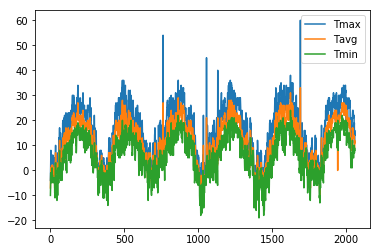

<Figure size 432x288 with 0 Axes>

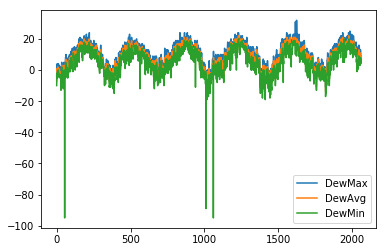

<Figure size 432x288 with 0 Axes>

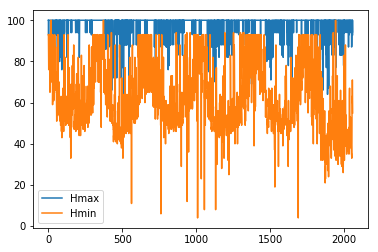

<Figure size 432x288 with 0 Axes>

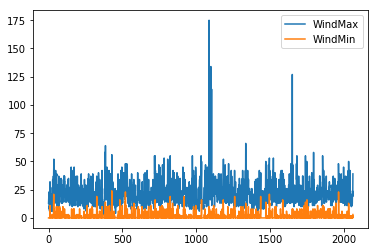

<Figure size 432x288 with 0 Axes>

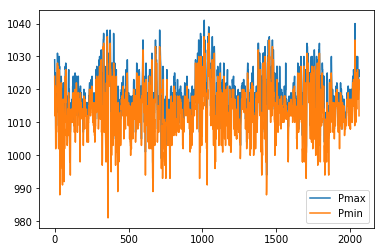

In [11]:
# Data Visualization
plt.figure()
df.plot(y=['Tmax', 'Tavg','Tmin'])
plt.figure()
df.plot(y=['DewMax', 'DewAvg','DewMin'])
plt.figure()
df.plot(y=['Hmax','Hmin'])
plt.figure()
df.plot(y=['WindMax','WindMin'])
plt.figure()
df.plot(y=['Pmax','Pmin'])
plt.show()

In [12]:
df.describe() # some general information about the data set

,Month,Day,Tmax,Tavg,Tmin,DewMax,DewAvg,DewMin,Hmax,Hmin,WindMax,WindMin,Pmax,Pmin
count,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000
mean,6.411650,15.663107,16.482524,11.167476,6.277184,10.291748,7.805825,4.642233,97.474272,62.370388,22.351942,1.611165,1018.377184,1013.208252
std,3.406485,8.790702,10.421761,9.075829,8.192699,7.563096,7.591768,8.746645,5.537879,16.719995,10.867783,3.111147,7.073263,7.700680
min,1.000000,1.000000,-7.000000,-13.000000,-19.000000,-11.000000,-14.000000,-95.000000,60.000000,4.000000,2.000000,0.000000,994.000000,981.000000
25%,4.000000,8.000000,8.000000,3.000000,0.000000,4.000000,2.000000,-1.000000,100.000000,50.000000,14.000000,0.000000,1014.000000,1009.000000
50%,6.000000,16.000000,18.000000,12.000000,7.000000,11.000000,8.000000,5.000000,100.000000,59.000000,21.000000,0.000000,1018.000000,1013.000000
75%,9.000000,23.000000,25.000000,19.000000,13.000000,16.000000,14.000000,11.000000,100.000000,74.000000,27.000000,2.000000,1023.000000,1018.000000
max,12.000000,32.000000,60.000000,33.000000,24.000000,32.000000,22.000000,20.000000,100.000000,100.000000,175.000000,24.000000,1041.000000,1037.000000


The concersion of the data framework to numpy array.

In [13]:
X = df.values

In [14]:
X.shape

(2060, 14)

Firs probe: Only 1 variable the Temperature average. We want to teach a neural network to predict the tomorrow temperatura average base on the previous average temperature infos

In [15]:
X_probe = X[:,3] # Tavg

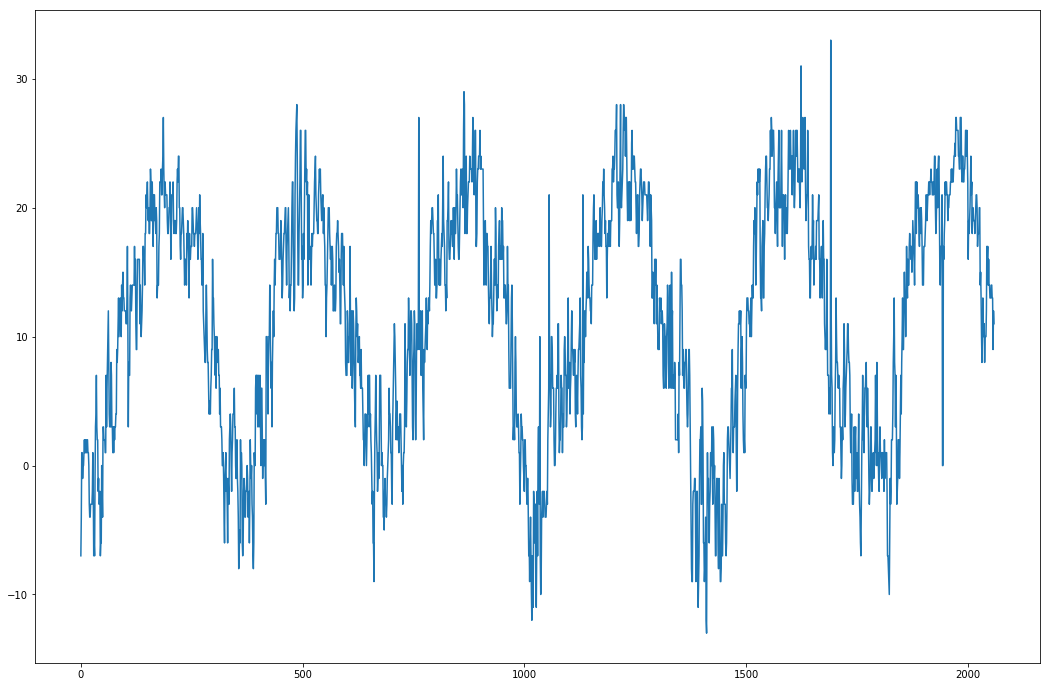

In [16]:
plt.figure(figsize=(18,12))
plt.plot(X_probe)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             24        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
Train on 113

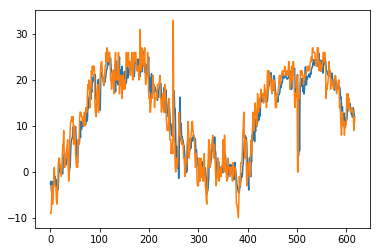

In [19]:
window_size=20
evalute_timeseries(X_probe,window_size,0)

So the model is working for 1 series, the result is quite good. Let's try it to predict 1 week ahead

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 16, 4)             24        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 2, 4)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
Train on 113

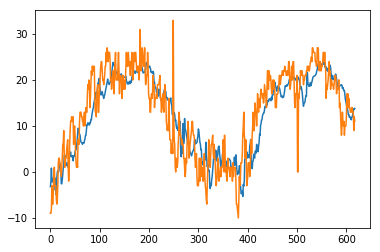

In [25]:
window_size=20
evalute_timeseries(X_probe,window_size,7)

So the model is working for 1 series, the result is quite good but you can see the errors are higher than previously. Let's see the future temperature 1 month ahead.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 16, 4)             24        
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 8, 4)              0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2, 4)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
Train on 111

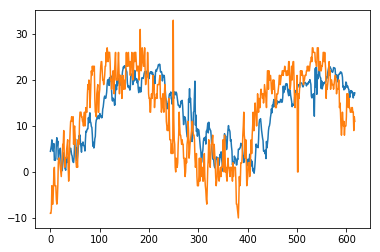

In [26]:
window_size=20
evalute_timeseries(X_probe,window_size,30)

Not the best, but it is useable. Lets take a look at the rest of the date, use all the feature we got!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 16, 4)             284       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 8, 4)              0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 2, 4)              0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 14)                126       
Total params: 494
Trainable params: 494
Non-trainable params: 0
_________________________________________________________________
Train on 113

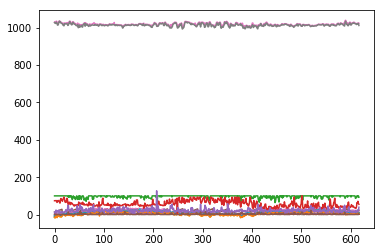

In [27]:
evalute_timeseries(X,window_size,0)

I am pretty sure this is awfull. Checking on the errors. Feature scaling would be nice.


Some additional thoughts:
- my data was collected from the following website:
 https://www.wunderground.com/history/monthly/hu/budapest-ferihegy/LHBP/date/2018-6
 
 Unfortunately I managed to get some outdated info and did not collected as much data as i wanted to.
 
- the algorithm is working, so teoretically it is capable of the prediction for a month above but it is not the sharpest tool yet.
 
- i did not finished with the exact predictions and some learning is also missing for example the all features included 1 week and 1 month ahead predictions.